# Creating heatmaps

One of the most common geospatial data visualization tasks is making heatmaps, or, more accurately, choropleth maps, where each polygon is colored in according to the value of an underlying variable associated with the polygon. 

Geopandas has some nice, pretty much out-of-the-box capabilities for doing this that will probably suffice for most purposes. 

https://geopandas.readthedocs.io/en/latest/mapping.html

To make publication-quality plots, some more customization may be required, and this can be somewhat tricky. Here, I walk through an example using postcode-level data for the UK and London.

In [1]:
import numpy as np
import pandas as pd
import geopandas
import geoplot
import geoplot.crs as gcrs
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib as mpl
import mapclassify as mc
import seaborn as sns
plt.style.use('seaborn')
mpl.rcParams['font.family'] = 'serif'

/home/seb/py36/lib/python3.6/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## 1) The underlying data

This is some fake data I created at the level of **postal area** for all of the UK as well as **postal districts** for London only. (https://en.wikipedia.org/wiki/Postcodes_in_the_United_Kingdom#Formatting) I didn't create data for all postcodes, to illustrate dealing with missing data later.

In [2]:
dpa = pd.read_csv('./data/randomdata_uk_postarea.csv')
dpd = pd.read_csv('./data/randomdata_uk_postdistrict.csv')

In [3]:
print(dpa.head())
print(dpd.head())

  post_area      x
0        AB  103.0
1        AL   16.0
2         B   91.0
3        BA   38.0
4        BB   73.0
  post_district      x
0           BR1  100.0
1           BR2   72.0
2           BR3   63.0
3           BR4   53.0
4           BR5   45.0


Note that both of the fake variables **start** at a strictly positive value -- this will require customizing the legend later. 

In [4]:
print(dpa.x.describe())
print('')
print(dpd.x.describe())

count    124.000000
mean      54.854839
std       28.386901
min       11.000000
25%       31.000000
50%       50.500000
75%       76.250000
max      109.000000
Name: x, dtype: float64

count    311.00000
mean      57.21865
std       28.28502
min       12.00000
25%       31.00000
50%       56.00000
75%       81.00000
max      110.00000
Name: x, dtype: float64


## 2) Shapefile

The shapefile for most of the UK postcodes is here: https://datashare.is.ed.ac.uk/handle/10283/2597. It does not have Northern Ireland. To illustrate how we can combine shapefiles, we will combine it with the data here: https://gadm.org/download_country_v3.html

### 2.1) Postal-area level

This is for the map for all of the UK

In [5]:
shppa = geopandas.read_file('./data/GB_Postcodes/PostalArea.shp')
shppa = shppa[['PostArea', 'geometry']].copy(deep=True)
shppa.columns = ['post_area', 'geometry']
shppa = shppa.to_crs("EPSG:4326")
crspa = shppa.crs

#### 2.1.1) Adding Northern Ireland

In [6]:
ni = geopandas.read_file('./data/gadm36_GBR_shp/gadm36_GBR_1.shp')
ni['post_area'] = 'BT'
ni = ni[ni.NAME_1 == 'Northern Ireland'][['post_area', 'geometry']].copy(deep=True)
ni = ni.to_crs("EPSG:4326")

/home/seb/py36/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


In [7]:
shppa = geopandas.GeoDataFrame(pd.concat([shppa, ni], ignore_index=True))

### 2.2) Postal-district level

This is for the London map

In [8]:
shppd = geopandas.read_file('./data/GB_Postcodes/PostalDistrict.shp')
shppd = shppd[['PostDist', 'geometry', 'Sprawl']].copy(deep=True)
shppd.columns = ['post_district', 'geometry', 'sprawl']
shppd = shppd.to_crs("EPSG:4326")
crspd = shppd.crs

## 3) Merge

### 3.1) Postal-area level

In [9]:
dpa = pd.merge(dpa, shppa, on='post_area', how='outer', indicator=True)
print(dpa._merge.value_counts())
dpa[dpa._merge == 'left_only']

both          121
left_only       3
right_only      0
Name: _merge, dtype: int64


,post_area,x,geometry,_merge
41,GY,93.0,None,left_only
51,IM,77.0,None,left_only
54,JE,100.0,None,left_only


We see that we do not have a map polygon for Guernsey, Isle of Man, and Jersey. This should be flagged when we report the visualization.

### 3.2) Postal-district level

In [10]:
dpd = pd.merge(dpd, shppd, on='post_district', how='outer', indicator=True)
# here we keep
# - the rows that are in both the data and the shapefile
# - the rows from the shapefile that are in the "London" sprawl
# - one additional row from the shapefile that is not in London sprawl, but
#   which is part of Greater London: "TW6"
dpd = dpd[(dpd._merge=='both') | (dpd.post_district == 'TW6') | (dpd.sprawl == 'London')]
print(dpd._merge.value_counts())

both          311
right_only     18
left_only       0
Name: _merge, dtype: int64


## 4) Additional constraint: plotting only a subset of the data

Suppose that the field we want to plot, `x`, is some count, and we only want to plot it if it is above a certain threshold, otherwise call it missing. For the purposes of the visualization exercise, we will set this threshold at 30. 

In [11]:
x_thresh = 30

### 4.1) Postal-area level

In [12]:
dpa = dpa[~pd.isnull(dpa.geometry)].reset_index(drop=True).copy(deep=True)
dpa.loc[dpa.x < x_thresh, 'x'] = np.nan
dpa = geopandas.GeoDataFrame(dpa, crs=crspa, geometry = dpa.geometry)
dpa_extent=dpa.total_bounds
# creating separate dataframes for the observed and the missing data
dpa_obs = dpa[(dpa.x >= x_thresh) & (~pd.isnull(dpa.x))].copy(deep=True)
dpa_missing = dpa[(dpa.x < x_thresh) | (pd.isnull(dpa.x))].copy(deep=True)
dpa_min_x = dpa.x.min()

### 4.2) Postal-district level

In [13]:
dpd = dpd.reset_index(drop=True).copy(deep=True)
dpd.loc[dpd.x < x_thresh, 'x'] = np.nan
dpd = geopandas.GeoDataFrame(dpd, crs=crspd, geometry = dpd.geometry)
dpd_extent=dpd.total_bounds
dpd_obs = dpd[(dpd.x >= x_thresh) & (~pd.isnull(dpd.x))].copy(deep=True)
dpd_missing = dpd[(dpd.x < x_thresh) | (pd.isnull(dpd.x))].copy(deep=True)
dpd_min_x = dpd.x.min()

## 5) Plotting

### 5.1) Making a nice colormap

Refer to the notebook `_1_colormaps.ipynb` to understand what is happening here

In [14]:
colors = mpl.cm.get_cmap('YlOrRd')
rbg_newcmap = [colors(i) for i in np.linspace(0.3, 0.6, 10)]
newcmap = mpl.colors.ListedColormap(rbg_newcmap)
colors = mpl.cm.get_cmap(newcmap)

### 5.2) Postal area level

/home/seb/py36/lib/python3.6/site-packages/geoplot/geoplot.py:625: FutureWarning:     You are passing non-geometry data to the GeoSeries constructor. Currently,
    it falls back to returning a pandas Series. But in the future, we will start
    to raise a TypeError instead.
  extent = gpd.GeoSeries(self.extent) if self.extent is not None else None


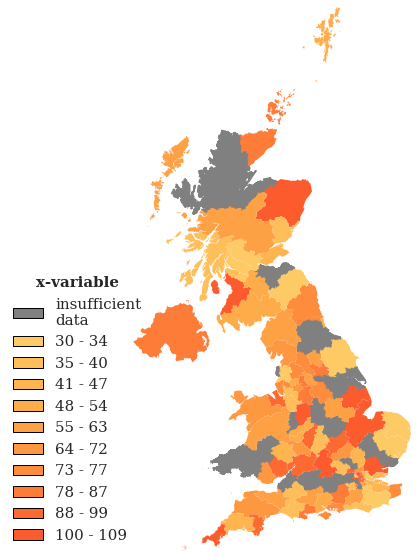

In [15]:
proj = projection=gcrs.Mercator()
# for the axes to be able to change the projection of underlying WGS84 data, 
# we need to have imported cartopy.crs
# https://geopandas.readthedocs.io/en/latest/gallery/cartopy_convert.html

# Generate a CartoPy figure
f, ax = plt.subplots(subplot_kw=dict(projection=proj), figsize=(10,10))

# create a scheme to assign colors to buckets of x-values
scheme = mc.Quantiles(dpa_obs['x'], k=10)

# add the missing-data polygons
geoplot.polyplot(dpa_missing, ax=ax, facecolor='gray',
                 edgecolor='gray', linewidth=1, extent=dpa_extent)

# add the polygons with data
geoplot.choropleth(
    dpa_obs,
    scheme=scheme,
    hue='x',
    ax=ax,
    zorder=1,
    legend=True,
    cmap=newcmap,
    extent=dpa_extent,
    legend_kwargs={'loc':'lower left',
                   'bbox_to_anchor':[-0.48, -0.01],
                   'fontsize':15,
                   'title':'x-variable',
                   'title_fontsize':15}
)

# customizing the legend - for each entry, we insert a patch and a color
leg = ax.get_legend()
leg.legendHandles.insert(0, mpl.patches.Patch(facecolor='gray', edgecolor='k', linewidth=1))  
leg.texts.insert(0, 'insufficient\ndata')

# legend entries for the non-missing data
for i, txt in enumerate(leg.texts[1:]):
    
    col = colors(np.linspace(0,1,10)[i]) # getting the right RGB color
    
    lbl = txt.get_text().split()
    if float(lbl[0]) == 0:
        lower = dpa_min_x # otherwise data will start at 0, when in fact, the lowest bucket 
                          # should start at the minimum value
    else:
        lower = round(float(lbl[0]))+1
    upper = round(float(lbl[2]))
    leg.texts.insert(i+1, '{} - {}'.format(int(lower), upper))
    leg.legendHandles.insert(i+1, mpl.patches.Patch(facecolor=col, edgecolor='k', linewidth=1))  

# re-building the legend
# this is a hacky solution, relies on internal methods, and may break 
# if the matplotlib code changes
leg._legend_box = None
leg._init_legend_box(leg.legendHandles[:11], leg.texts[:11])
leg._set_loc(leg._loc)
leg.set_title('x-variable', prop={'size': 15, 'weight': 'bold'})  

plt.show()

### 5.3) Postal district level

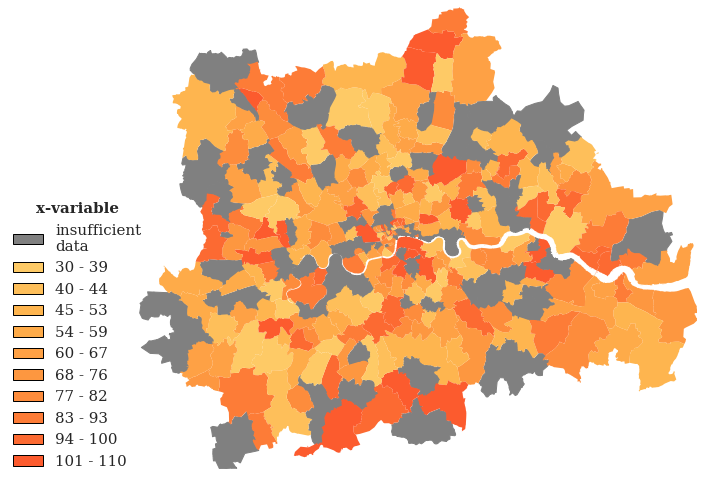

In [16]:
proj = projection=gcrs.Mercator()
f, ax = plt.subplots(subplot_kw=dict(projection=proj), figsize=(10,10))
scheme = mc.Quantiles(dpd_obs['x'], k=10)
geoplot.polyplot(dpd_missing, ax=ax, facecolor='gray',
                 edgecolor='gray', linewidth=1, extent=dpd_extent)
geoplot.choropleth(
    dpd_obs,
    scheme=scheme,
    hue='x',
    ax=ax,
    zorder=1,
    legend=True,
    cmap=newcmap,
    extent=dpd_extent,
    legend_kwargs={'loc':'lower left',
                   'bbox_to_anchor':[-0.25, -0.03],
                   'fontsize':15,
                   'title':'x-variable',
                   'title_fontsize':15}
)

leg = ax.get_legend()
leg.legendHandles.insert(0, mpl.patches.Patch(facecolor='gray', edgecolor='k', linewidth=1))  
leg.texts.insert(0, 'insufficient\ndata')

for i, txt in enumerate(leg.texts[1:]):
    
    col = colors(np.linspace(0,1,10)[i])
    
    lbl = txt.get_text().split()
    if float(lbl[0]) == 0:
        lower = dpd_min_x 
    else:
        lower = round(float(lbl[0]))+1
    upper = round(float(lbl[2]))
    leg.texts.insert(i+1, '{} - {}'.format(int(lower), upper))
    leg.legendHandles.insert(i+1, mpl.patches.Patch(facecolor=col, edgecolor='k', linewidth=1))  

leg._legend_box = None
leg._init_legend_box(leg.legendHandles[:11], leg.texts[:11])
leg._set_loc(leg._loc)
leg.set_title('x-variable', prop={'size': 15, 'weight': 'bold'})  

plt.show()